# LinkedIn Posts Data Analysis
## Notebook 04: Content Analysis (Parts 1-4)

This notebook performs deep-dive analysis on post content features including hashtags, emojis, mentions, and URLs.

### Objectives:
1. **Hashtag Analysis** - Why do hashtags seem to reduce engagement?
2. **Emoji Analysis** - Which emojis help vs hurt engagement?
3. **Mention Analysis** - Impact of mentioning people and companies
4. **URL Content Analysis** - Deep dive into link types and positioning

### Key Questions:
- Why do viral posts have 47% fewer hashtags and 41% fewer emojis?
- Which specific hashtags and emojis perform best?
- Does mentioning influencers boost engagement?

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter
from urllib.parse import urlparse
import json
import warnings
warnings.filterwarnings('ignore')

# Configure pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Data

In [75]:
# Load cleaned dataset
df = pd.read_csv('../output/tables/linkedin_posts_cleaned.csv')
df['postedAt'] = pd.to_datetime(df['postedAt'], format='mixed', utc=True)

print(f"Dataset loaded: {df.shape}")
print(f"Posts with text: {(df['text_length'] > 0).sum()}")

Dataset loaded: (11227, 73)
Posts with text: 11213


## 1. Hashtag Deep Dive

### 1.1 Extract All Hashtags

In [76]:
# Function to extract hashtags from text
def extract_hashtags(text):
    """Extract all hashtags from text"""
    if pd.isna(text) or text == '':
        return []
    # Match hashtags (# followed by word characters)
    hashtags = re.findall(r'#(\w+)', text)
    return [tag.lower() for tag in hashtags]

# Extract hashtags
df['hashtags_list'] = df['text'].apply(extract_hashtags)
df['num_hashtags'] = df['hashtags_list'].apply(len)

print(f"Posts with hashtags: {(df['num_hashtags'] > 0).sum()} ({(df['num_hashtags'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Total hashtags found: {df['num_hashtags'].sum()}")
print(f"Avg hashtags per post (all): {df['num_hashtags'].mean():.2f}")
print(f"Avg hashtags per post (posts with hashtags): {df[df['num_hashtags'] > 0]['num_hashtags'].mean():.2f}")

Posts with hashtags: 1902 (16.9%)
Total hashtags found: 8230
Avg hashtags per post (all): 0.73
Avg hashtags per post (posts with hashtags): 4.33


In [77]:
# Count all hashtags
all_hashtags = []
for hashtags in df['hashtags_list']:
    all_hashtags.extend(hashtags)

hashtag_counts = Counter(all_hashtags)
top_hashtags = pd.DataFrame(hashtag_counts.most_common(50), columns=['Hashtag', 'Count'])

print(f"\nUnique hashtags: {len(hashtag_counts)}")
print(f"\nTop 30 Hashtags by Usage:")
print(top_hashtags.head(30).to_string(index=False))


Unique hashtags: 2163

Top 30 Hashtags by Usage:
               Hashtag  Count
        venturecapital    430
                    vc    386
               funding    366
               startup    358
                    ai    343
               founder    339
              business    336
             investing    335
          entrepreneur    335
                     1    121
          futureofwork     97
              startups     95
            innovation     91
            investment     85
                  20vc     77
         cybersecurity     58
                hiring     57
              founders     56
            healthcare     47
            leadership     42
            healthtech     40
                  seed     39
         startupadvice     38
               fintech     38
                     2     34
      entrepreneurship     31
            cybersparx     31
artificialintelligence     26
  healthcareinnovation     25
           fundraising     24


### 1.2 Engagement by Hashtag Count

In [78]:
# Create hashtag count bins
df['hashtag_count_bin'] = df['num_hashtags'].apply(
    lambda x: '0' if x == 0 else ('1' if x == 1 else ('2-3' if x <= 3 else ('4-5' if x <= 5 else '6+')))
)

# Engagement by hashtag count
hashtag_count_engagement = df.groupby('hashtag_count_bin').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

hashtag_count_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
hashtag_count_engagement = hashtag_count_engagement.reindex(['0', '1', '2-3', '4-5', '6+'])

print("\nEngagement by Hashtag Count:")
print(hashtag_count_engagement)

hashtag_count_engagement.to_csv('../output/tables/engagement_by_hashtag_count.csv')


Engagement by Hashtag Count:
                   Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
hashtag_count_bin                                                             
0                          329.72             115.00        9325     289.59   
1                          228.61              83.00         555     201.02   
2-3                        275.33             108.50         410     231.53   
4-5                        183.37              91.00         317     154.71   
6+                         493.91             241.50         620     432.67   

                   Avg_Shares  Avg_Comments  
hashtag_count_bin                            
0                       14.38         25.74  
1                        9.01         18.59  
2-3                     12.07         31.73  
4-5                      8.43         20.23  
6+                      10.45         50.79  


In [79]:
# Visualize engagement by hashtag count
hashtag_count_plot = hashtag_count_engagement.reset_index()
hashtag_count_plot.columns = ['Hashtag_Count', 'Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=hashtag_count_plot['Hashtag_Count'],
    y=hashtag_count_plot['Avg_Engagement'],
    name='Average',
    text=hashtag_count_plot['Avg_Engagement'],
    texttemplate='%{text:.0f}',
    textposition='outside',
    marker_color='lightblue'
))

fig.add_trace(go.Scatter(
    x=hashtag_count_plot['Hashtag_Count'],
    y=hashtag_count_plot['Median_Engagement'],
    name='Median',
    mode='lines+markers',
    line=dict(color='red', width=2),
    marker=dict(size=8)
))

fig.update_layout(
    title='Engagement by Number of Hashtags',
    xaxis_title='Number of Hashtags',
    yaxis_title='Total Engagement',
    height=500
)

fig.show()
fig.write_html('../output/figures/engagement_by_hashtag_count.html')

### 1.3 Performance of Specific Hashtags

In [80]:
# Analyze engagement for top hashtags (min 10 occurrences)
hashtag_engagement = []

for hashtag, count in top_hashtags.head(30).values:
    # Get posts with this hashtag
    posts_with_tag = df[df['hashtags_list'].apply(lambda tags: hashtag in tags)]
    
    if len(posts_with_tag) >= 10:
        hashtag_engagement.append({
            'Hashtag': f'#{hashtag}',
            'Count': count,
            'Avg_Engagement': posts_with_tag['total_engagement'].mean(),
            'Median_Engagement': posts_with_tag['total_engagement'].median(),
            'Avg_Likes': posts_with_tag['numLikes'].mean(),
            'Avg_Shares': posts_with_tag['numShares'].mean(),
            'Avg_Comments': posts_with_tag['numComments'].mean()
        })

hashtag_performance = pd.DataFrame(hashtag_engagement).round(2)
hashtag_performance = hashtag_performance.sort_values('Avg_Engagement', ascending=False)

print("\nTop Hashtags by Average Engagement (min 10 uses):")
print(hashtag_performance.head(20).to_string(index=False))

hashtag_performance.to_csv('../output/tables/top_hashtags_by_engagement.csv', index=False)


Top Hashtags by Average Engagement (min 10 uses):
                Hashtag  Count  Avg_Engagement  Median_Engagement  Avg_Likes  Avg_Shares  Avg_Comments
               #funding    366          759.64             504.00     672.19       10.71         76.74
          #entrepreneur    335          755.16             501.00     668.33       10.67         76.16
             #investing    335          754.40             501.00     667.57       10.66         76.17
              #business    336          753.01             501.00     666.27       10.63         76.10
               #founder    339          750.29             501.00     663.63       10.68         75.98
               #startup    358          732.14             484.50     644.37       11.64         76.13
                    #vc    386          679.28             429.00     600.34       10.01         68.93
        #venturecapital    430          668.37             406.00     583.54       11.40         73.43
                  #see

In [81]:
# Visualize top hashtags by engagement
top_20_hashtags = hashtag_performance.head(20)

fig = px.bar(
    top_20_hashtags,
    x='Avg_Engagement',
    y='Hashtag',
    orientation='h',
    title='Top 20 Hashtags by Average Engagement',
    labels={'Avg_Engagement': 'Average Total Engagement', 'Hashtag': 'Hashtag'},
    text='Avg_Engagement',
    color='Avg_Engagement',
    color_continuous_scale='Viridis',
    hover_data=['Count', 'Median_Engagement']
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=700, showlegend=False)
fig.update_yaxes(categoryorder='total ascending')
fig.show()
fig.write_html('../output/figures/top_hashtags_by_engagement.html')

### 1.4 Hashtag Analysis by Content Type

In [82]:
# Hashtag usage by content type
major_content_types = ['Image', 'Video', 'Article', 'Text Only', 'Reshare']

content_hashtag_usage = df[df['primary_content_type'].isin(major_content_types)].groupby('primary_content_type').agg({
    'num_hashtags': ['mean', 'median'],
    'has_hashtag': lambda x: (x == True).sum() / len(x) * 100,
    'urn': 'count'
}).round(2)

content_hashtag_usage.columns = ['Avg_Hashtags', 'Median_Hashtags', 'Pct_With_Hashtags', 'Post_Count']
content_hashtag_usage = content_hashtag_usage.sort_values('Avg_Hashtags', ascending=False)

print("\nHashtag Usage by Content Type:")
print(content_hashtag_usage)

content_hashtag_usage.to_csv('../output/tables/hashtag_usage_by_content_type.csv')


Hashtag Usage by Content Type:
                      Avg_Hashtags  Median_Hashtags  Pct_With_Hashtags  \
primary_content_type                                                     
Text Only                     1.28             0.00              25.99   
Video                         1.11             0.00              19.88   
Image                         0.73             0.00              18.39   
Article                       0.59             0.00              14.71   
Reshare                       0.22             0.00               8.15   

                      Post_Count  
primary_content_type              
Text Only                   1489  
Video                       1620  
Image                       3970  
Article                     1625  
Reshare                     2405  


## 2. Emoji Deep Dive

### 2.1 Extract and Categorize Emojis

In [83]:
# Function to extract emojis
def extract_emojis(text):
    """Extract all emojis from text using Unicode ranges"""
    if pd.isna(text) or text == '':
        return []
    
    # Extended emoji pattern covering more ranges
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002700-\U000027BF"  # Dingbats
        "]+", flags=re.UNICODE
    )
    
    emojis = emoji_pattern.findall(text)
    return emojis

# Extract emojis
df['emojis_list'] = df['text'].apply(extract_emojis)
df['num_emojis'] = df['emojis_list'].apply(len)

print(f"Posts with emojis: {(df['num_emojis'] > 0).sum()} ({(df['num_emojis'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Total emojis found: {df['num_emojis'].sum()}")
print(f"Avg emojis per post (all): {df['num_emojis'].mean():.2f}")
print(f"Avg emojis per post (posts with emojis): {df[df['num_emojis'] > 0]['num_emojis'].mean():.2f}")

Posts with emojis: 3912 (34.8%)
Total emojis found: 16682
Avg emojis per post (all): 1.49
Avg emojis per post (posts with emojis): 4.26


In [84]:
# Count all emojis
all_emojis = []
for emojis in df['emojis_list']:
    all_emojis.extend(emojis)

emoji_counts = Counter(all_emojis)
top_emojis = pd.DataFrame(emoji_counts.most_common(50), columns=['Emoji', 'Count'])

print(f"\nUnique emojis: {len(emoji_counts)}")
print(f"\nTop 30 Emojis by Usage:")
print(top_emojis.head(30).to_string(index=False))


Unique emojis: 4494

Top 30 Emojis by Usage:
Emoji  Count
    🚀    696
    ️    491
    👇    490
    ⚡    473
    ✅    465
    🔥    330
    👉    289
    ✨    242
    🚨    227
    🔗    165
    💡    155
    🔹    151
    👋    137
   ➡️    137
    📈    134
    👀    130
    🤖    128
    🤝    110
   ❤️    107
    👏    104
    📍    101
    🎉    100
    🌟    100
    🙌     84
   🇺🇸     81
    🙏     79
    💰     78
    🤯     77
    💥     72
    🧠     72


### 2.2 Engagement by Emoji Count

In [85]:
# Create emoji count bins
df['emoji_count_bin'] = df['num_emojis'].apply(
    lambda x: '0' if x == 0 else ('1-2' if x <= 2 else ('3-5' if x <= 5 else ('6-10' if x <= 10 else '11+')))
)

# Engagement by emoji count
emoji_count_engagement = df.groupby('emoji_count_bin').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

emoji_count_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
emoji_count_engagement = emoji_count_engagement.reindex(['0', '1-2', '3-5', '6-10', '11+'])

print("\nEngagement by Emoji Count:")
print(emoji_count_engagement)

emoji_count_engagement.to_csv('../output/tables/engagement_by_emoji_count.csv')


Engagement by Emoji Count:
                 Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
emoji_count_bin                                                             
0                        354.13             117.00        7315     311.74   
1-2                      251.57              97.00        2447     219.32   
3-5                      310.55             133.00         841     268.93   
6-10                     343.30             150.00         399     295.82   
11+                      331.36             156.00         225     280.11   

                 Avg_Shares  Avg_Comments  
emoji_count_bin                            
0                     14.06         28.33  
1-2                   10.19         22.06  
3-5                   16.50         25.13  
6-10                  18.84         28.64  
11+                   17.77         33.48  


In [86]:
# Visualize engagement by emoji count
emoji_count_plot = emoji_count_engagement.reset_index()
emoji_count_plot.columns = ['Emoji_Count', 'Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']

fig = px.box(
    df,
    x='emoji_count_bin',
    y='total_engagement',
    title='Engagement Distribution by Emoji Count',
    labels={'emoji_count_bin': 'Number of Emojis', 'total_engagement': 'Total Engagement'},
    category_orders={'emoji_count_bin': ['0', '1-2', '3-5', '6-10', '11+']},
    color='emoji_count_bin'
)

fig.update_layout(height=600, showlegend=False)
fig.show()
fig.write_html('../output/figures/engagement_by_emoji_count.html')

### 2.3 Performance of Specific Emojis

In [87]:
# Analyze engagement for top emojis (min 20 occurrences)
emoji_engagement = []

for emoji, count in top_emojis.head(40).values:
    # Get posts with this emoji
    posts_with_emoji = df[df['emojis_list'].apply(lambda emojis: emoji in emojis)]
    
    if len(posts_with_emoji) >= 20:
        emoji_engagement.append({
            'Emoji': emoji,
            'Count': count,
            'Avg_Engagement': posts_with_emoji['total_engagement'].mean(),
            'Median_Engagement': posts_with_emoji['total_engagement'].median(),
            'Avg_Likes': posts_with_emoji['numLikes'].mean(),
            'Avg_Shares': posts_with_emoji['numShares'].mean(),
            'Avg_Comments': posts_with_emoji['numComments'].mean()
        })

emoji_performance = pd.DataFrame(emoji_engagement).round(2)
emoji_performance = emoji_performance.sort_values('Avg_Engagement', ascending=False)

print("\nTop Emojis by Average Engagement (min 20 uses):")
print(emoji_performance.head(25).to_string(index=False))

emoji_performance.to_csv('../output/tables/top_emojis_by_engagement.csv', index=False)


Top Emojis by Average Engagement (min 20 uses):
Emoji  Count  Avg_Engagement  Median_Engagement  Avg_Likes  Avg_Shares  Avg_Comments
    ⚡    473          617.14             157.00     547.22       40.96         28.97
    🌍     68          583.93             183.50     530.60       20.04         33.28
    👋    137          566.21             325.00     471.05       56.54         38.61
    🧠     72          503.80             158.00     452.39       17.88         33.52
   ⬇️     68          496.77             100.00     440.84       23.76         32.18
    🤯     77          427.72              75.50     372.14       16.93         38.65
    🎮     52          406.88             229.00     334.67       31.96         40.24
    🎉    100          378.55             165.50     315.42       27.83         35.30
   ❤️    107          368.76             127.00     329.70       12.83         26.22
    📣     66          363.08             175.00     304.58       26.95         31.55
    🙏     79    

In [88]:
# Visualize top emojis by engagement
top_25_emojis = emoji_performance.head(25)

fig = px.bar(
    top_25_emojis,
    x='Avg_Engagement',
    y='Emoji',
    orientation='h',
    title='Top 25 Emojis by Average Engagement (min 20 uses)',
    labels={'Avg_Engagement': 'Average Total Engagement', 'Emoji': 'Emoji'},
    text='Avg_Engagement',
    color='Avg_Engagement',
    color_continuous_scale='RdYlGn',
    hover_data=['Count', 'Median_Engagement']
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=800, showlegend=False)
fig.update_yaxes(categoryorder='total ascending')
fig.show()
fig.write_html('../output/figures/top_emojis_by_engagement.html')

### 2.4 Emoji Categories

In [89]:
# Categorize emojis (simple categorization based on common patterns)
def categorize_emoji(emoji):
    """Categorize emoji by type"""
    # Professional/Business
    if emoji in ['💡', '📊', '📈', '💼', '📉', '🎯', '✅', '⚡', '🔥', '💪', '🚀', '⭐', '🌟']:
        return 'Professional'
    # Positive emotions
    elif emoji in ['😊', '😃', '🙂', '😄', '😁', '🤗', '❤️', '💙', '💚', '🧡', '💛', '💜']:
        return 'Positive Emotion'
    # Celebrations
    elif emoji in ['🎉', '🎊', '🥳', '🎈', '✨', '🏆', '🥇', '👏', '🙌']:
        return 'Celebration'
    # Pointers/Arrows
    elif emoji in ['👉', '👇', '👆', '👈', '➡️', '⬇️', '⬆️', '⬅️', '↗️', '↘️']:
        return 'Pointer/Arrow'
    # Thinking/Questioning
    elif emoji in ['🤔', '💭', '🧠', '❓', '❔', '💬']:
        return 'Thinking/Question'
    else:
        return 'Other'

# Categorize top emojis
emoji_performance['Category'] = emoji_performance['Emoji'].apply(categorize_emoji)

# Aggregate by category
emoji_category_performance = emoji_performance.groupby('Category').agg({
    'Avg_Engagement': 'mean',
    'Count': 'sum',
    'Emoji': 'count'
}).round(2)

emoji_category_performance.columns = ['Avg_Engagement', 'Total_Uses', 'Num_Emojis']
emoji_category_performance = emoji_category_performance.sort_values('Avg_Engagement', ascending=False)

print("\nEngagement by Emoji Category:")
print(emoji_category_performance)


Engagement by Emoji Category:
                   Avg_Engagement  Total_Uses  Num_Emojis
Category                                                 
Thinking/Question          503.80          72           1
Positive Emotion           368.76         107           1
Other                      328.88        2370          20
Pointer/Arrow              323.73         984           4
Professional               294.33        2405           8
Celebration                254.13         530           4


## 3. Mention Analysis

### 3.1 Extract Mentions from Attributes

In [90]:
# Load raw data to access attributes field
with open('../dataset_linkedin-post_2025-11-23_06-22-48-536.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f"Loaded {len(raw_data)} posts from raw data")

Loaded 11227 posts from raw data


In [91]:
# Extract mentions from attributes
def extract_mentions(attributes):
    """Extract mentions from attributes field"""
    if not attributes or not isinstance(attributes, list):
        return {'person_mentions': [], 'company_mentions': []}
    
    person_mentions = []
    company_mentions = []
    
    for attr in attributes:
        if attr.get('type') == 'PROFILE_MENTION' and 'profile' in attr:
            name = f"{attr['profile'].get('firstName', '')} {attr['profile'].get('lastName', '')}".strip()
            if name:
                person_mentions.append(name)
        elif attr.get('type') == 'COMPANY_NAME' and 'company' in attr:
            company_name = attr['company'].get('name', '')
            if company_name:
                company_mentions.append(company_name)
    
    return {'person_mentions': person_mentions, 'company_mentions': company_mentions}

# Extract mentions for all posts
mentions_data = []
for post in raw_data:
    mentions = extract_mentions(post.get('attributes', []))
    mentions_data.append({
        'urn': post.get('urn'),
        'person_mentions': mentions['person_mentions'],
        'company_mentions': mentions['company_mentions'],
        'num_person_mentions': len(mentions['person_mentions']),
        'num_company_mentions': len(mentions['company_mentions']),
        'total_mentions': len(mentions['person_mentions']) + len(mentions['company_mentions'])
    })

mentions_df = pd.DataFrame(mentions_data)

# Merge with main dataframe
df = df.merge(mentions_df, on='urn', how='left')

print(f"\nPosts with person mentions: {(df['num_person_mentions'] > 0).sum()} ({(df['num_person_mentions'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Posts with company mentions: {(df['num_company_mentions'] > 0).sum()} ({(df['num_company_mentions'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Total person mentions: {df['num_person_mentions'].sum()}")
print(f"Total company mentions: {df['num_company_mentions'].sum()}")


Posts with person mentions: 5367 (47.8%)
Posts with company mentions: 6290 (56.0%)
Total person mentions: 19483
Total company mentions: 19106


### 3.2 Engagement by Mention Count

In [92]:
# Create mention count bins
df['mention_count_bin'] = df['total_mentions'].apply(
    lambda x: '0' if x == 0 else ('1-2' if x <= 2 else ('3-5' if x <= 5 else '6+'))
)

# Engagement by mention count
mention_count_engagement = df.groupby('mention_count_bin').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

mention_count_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
mention_count_engagement = mention_count_engagement.reindex(['0', '1-2', '3-5', '6+'])

print("\nEngagement by Total Mention Count:")
print(mention_count_engagement)

mention_count_engagement.to_csv('../output/tables/engagement_by_mention_count.csv')


Engagement by Total Mention Count:
                   Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
mention_count_bin                                                             
0                          410.16             130.00        3754     361.28   
1-2                        266.49              89.00        3391     232.84   
3-5                        214.74             101.50        2092     190.78   
6+                         395.01             163.00        1990     341.38   

                   Avg_Shares  Avg_Comments  
mention_count_bin                            
0                       16.54         32.34  
1-2                     11.09         22.56  
3-5                      8.14         15.82  
6+                      18.31         35.32  


In [93]:
# Compare person vs company mentions
mention_type_comparison = pd.DataFrame({
    'Mention_Type': ['No Mentions', 'Person Mentions Only', 'Company Mentions Only', 'Both'],
    'Avg_Engagement': [
        df[(df['num_person_mentions'] == 0) & (df['num_company_mentions'] == 0)]['total_engagement'].mean(),
        df[(df['num_person_mentions'] > 0) & (df['num_company_mentions'] == 0)]['total_engagement'].mean(),
        df[(df['num_person_mentions'] == 0) & (df['num_company_mentions'] > 0)]['total_engagement'].mean(),
        df[(df['num_person_mentions'] > 0) & (df['num_company_mentions'] > 0)]['total_engagement'].mean()
    ],
    'Post_Count': [
        len(df[(df['num_person_mentions'] == 0) & (df['num_company_mentions'] == 0)]),
        len(df[(df['num_person_mentions'] > 0) & (df['num_company_mentions'] == 0)]),
        len(df[(df['num_person_mentions'] == 0) & (df['num_company_mentions'] > 0)]),
        len(df[(df['num_person_mentions'] > 0) & (df['num_company_mentions'] > 0)])
    ]
}).round(2)

print("\nEngagement by Mention Type:")
print(mention_type_comparison.to_string(index=False))

mention_type_comparison.to_csv('../output/tables/engagement_by_mention_type.csv', index=False)


Engagement by Mention Type:
         Mention_Type  Avg_Engagement  Post_Count
          No Mentions          410.16        3754
 Person Mentions Only          269.61        1183
Company Mentions Only          339.06        2106
                 Both          264.33        4184


In [94]:
# Visualize mention type comparison
fig = px.bar(
    mention_type_comparison,
    x='Mention_Type',
    y='Avg_Engagement',
    title='Average Engagement by Mention Type',
    labels={'Mention_Type': 'Mention Type', 'Avg_Engagement': 'Average Total Engagement'},
    text='Avg_Engagement',
    color='Avg_Engagement',
    color_continuous_scale='Blues',
    hover_data=['Post_Count']
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=500, showlegend=False)
fig.show()
fig.write_html('../output/figures/engagement_by_mention_type.html')

### 3.3 Most Mentioned People and Companies

In [95]:
# Count top mentioned people
all_person_mentions = []
for mentions in df['person_mentions']:
    if isinstance(mentions, list):
        all_person_mentions.extend(mentions)

person_mention_counts = Counter(all_person_mentions)
top_person_mentions = pd.DataFrame(person_mention_counts.most_common(30), columns=['Person', 'Mention_Count'])

print("\nTop 30 Most Mentioned People:")
print(top_person_mentions.to_string(index=False))

top_person_mentions.to_csv('../output/tables/top_mentioned_people.csv', index=False)


Top 30 Most Mentioned People:
           Person  Mention_Count
     Jordan Mazer            154
    Jordan Carver            146
      Guru Chahal            134
      Andrew Chen            127
  Harry Stebbings             69
      Troy Kirwin             56
Erin Price-Wright             56
 Nnamdi Iregbulem             52
 Samira Behrouzan             50
  Katherine Boyle             50
        Bryan Kim             50
   David Ulevitch             47
      Ravi Mhatre             47
    Bella Nazzari             46
     Jonathan Lai             46
      Seema Amble             44
      Jennifer Li             42
       Macy Mills             41
Mati Staniszewski             40
     Jensen Huang             40
        Ilan Twig             40
       Andrew Lee             39
          Yoko Li             38
      Kieran Hill             38
      Dylan Field             37
      Lester Chen             36
      David Haber             36
      Paul Bonnet             35
      Paul M

In [96]:
# Count top mentioned companies
all_company_mentions = []
for mentions in df['company_mentions']:
    if isinstance(mentions, list):
        all_company_mentions.extend(mentions)

company_mention_counts = Counter(all_company_mentions)
top_company_mentions = pd.DataFrame(company_mention_counts.most_common(30), columns=['Company', 'Mention_Count'])

print("\nTop 30 Most Mentioned Companies:")
print(top_company_mentions.to_string(index=False))

top_company_mentions.to_csv('../output/tables/top_mentioned_companies.csv', index=False)


Top 30 Most Mentioned Companies:
                  Company  Mention_Count
      Andreessen Horowitz            673
            a16z speedrun            586
               Lightspeed            437
                Anthropic            261
                   Antler            179
               ElevenLabs            148
                  Decagon            147
           Menlo Ventures            140
        TECH WEEK by a16z            129
           Index Ventures            118
      First Round Capital            115
                   OpenAI            109
                    Accel            107
          Sequoia Capital            102
          SemperVirens VC             99
                  Lovable             87
                     20VC             83
       boldstart ventures             80
               Mistral AI             78
Amazon Web Services (AWS)             76
         General Catalyst             73
                   NVIDIA             69
                    Nav

In [97]:
# Visualize top mentioned people
fig = px.bar(
    top_person_mentions.head(20),
    x='Mention_Count',
    y='Person',
    orientation='h',
    title='Top 20 Most Mentioned People',
    labels={'Mention_Count': 'Number of Mentions', 'Person': 'Person'},
    text='Mention_Count',
    color='Mention_Count',
    color_continuous_scale='Purples'
)

fig.update_traces(textposition='outside')
fig.update_layout(height=700, showlegend=False)
fig.update_yaxes(categoryorder='total ascending')
fig.show()
fig.write_html('../output/figures/top_mentioned_people.html')

In [98]:
# Visualize top mentioned companies
fig = px.bar(
    top_company_mentions.head(20),
    x='Mention_Count',
    y='Company',
    orientation='h',
    title='Top 20 Most Mentioned Companies',
    labels={'Mention_Count': 'Number of Mentions', 'Company': 'Company'},
    text='Mention_Count',
    color='Mention_Count',
    color_continuous_scale='Oranges'
)

fig.update_traces(textposition='outside')
fig.update_layout(height=700, showlegend=False)
fig.update_yaxes(categoryorder='total ascending')
fig.show()
fig.write_html('../output/figures/top_mentioned_companies.html')

## 4. URL Content Analysis

### 4.1 LinkedIn Native vs External URLs

In [99]:
# Re-extract URLs (already done in Notebook 03, but ensuring we have it)
def extract_urls(text):
    if pd.isna(text) or text == '':
        return []
    url_pattern = r'https?://[^\s]+'
    return re.findall(url_pattern, text)

def extract_domain(url):
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return None

df['extracted_urls'] = df['text'].apply(extract_urls)
df['url_domains'] = df['extracted_urls'].apply(lambda urls: [extract_domain(url) for url in urls if extract_domain(url)])
df['primary_domain'] = df['url_domains'].apply(lambda x: x[0] if len(x) > 0 else None)

# Categorize URLs
def categorize_url(domain):
    if not domain:
        return 'No URL'
    elif 'lnkd.in' in domain or 'linkedin.com' in domain:
        return 'LinkedIn Native'
    elif domain in ['bit.ly', 'ow.ly', 'tinyurl.com', 'goo.gl', 't.co']:
        return 'Link Shortener'
    else:
        return 'External Direct'

df['url_category'] = df['primary_domain'].apply(categorize_url)

# Engagement by URL category
url_category_engagement = df.groupby('url_category').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

url_category_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
url_category_engagement = url_category_engagement.sort_values('Avg_Engagement', ascending=False)

print("\nEngagement by URL Category:")
print(url_category_engagement)

url_category_engagement.to_csv('../output/tables/engagement_by_url_category.csv')


Engagement by URL Category:
                 Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
url_category                                                                
LinkedIn Native          439.58             138.00        2589     389.68   
Link Shortener           378.38             192.00         149     315.79   
External Direct          367.79             130.50         256     310.16   
No URL                   290.31             106.00        8233     253.72   

                 Avg_Shares  Avg_Comments  
url_category                               
LinkedIn Native       22.38         27.52  
Link Shortener        37.06         25.53  
External Direct       22.14         35.48  
No URL                10.21         26.38  


In [100]:
# Visualize URL category performance
url_cat_plot = url_category_engagement.reset_index()
url_cat_plot.columns = ['URL_Category', 'Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']

fig = px.bar(
    url_cat_plot,
    x='URL_Category',
    y='Avg_Engagement',
    title='Average Engagement by URL Type',
    labels={'URL_Category': 'URL Type', 'Avg_Engagement': 'Average Total Engagement'},
    text='Avg_Engagement',
    color='Avg_Engagement',
    color_continuous_scale='Teal',
    hover_data=['Post_Count', 'Median_Engagement']
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=500, showlegend=False)
fig.show()
fig.write_html('../output/figures/engagement_by_url_category.html')

### 4.2 Multiple URLs Impact

In [101]:
# Engagement by number of URLs
df['url_count_bin'] = df['url_count'].apply(
    lambda x: '0' if x == 0 else ('1' if x == 1 else ('2' if x == 2 else '3+'))
)

url_count_engagement = df.groupby('url_count_bin').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

url_count_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
url_count_engagement = url_count_engagement.reindex(['0', '1', '2', '3+'])

print("\nEngagement by Number of URLs:")
print(url_count_engagement)

url_count_engagement.to_csv('../output/tables/engagement_by_url_count.csv')


Engagement by Number of URLs:
               Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
url_count_bin                                                             
0                      290.31             106.00        8233     253.72   
1                      407.91             125.00        2408     362.08   
2                      587.97             195.50         284     520.52   
3+                     461.49             262.00         302     382.85   

               Avg_Shares  Avg_Comments  
url_count_bin                            
0                   10.21         26.38  
1                   20.14         25.69  
2                   28.69         38.76  
3+                  41.38         37.26  


---

# Parts 5-8: Text Quality & LLM-Powered Analysis

The following sections use LLM calls to analyze content patterns that are difficult to detect with traditional NLP.

## 5. Text Content Quality Analysis

### 5.1 Question Posts

In [102]:
# Detect questions in posts
def has_question(text):
    """Check if text contains questions"""
    if pd.isna(text) or text == '':
        return False
    return '?' in text

df['has_question'] = df['text'].apply(has_question)
df['question_count'] = df['text'].apply(lambda x: x.count('?') if pd.notna(x) else 0)

# Engagement analysis for question posts
question_engagement = df.groupby('has_question').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

question_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']

print("Engagement by Question Posts:")
print(question_engagement)
print(f"\nPosts with questions: {df['has_question'].sum()} ({df['has_question'].sum()/len(df)*100:.1f}%)")

question_engagement.to_csv('../output/tables/engagement_by_question_posts.csv')

Engagement by Question Posts:
              Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
has_question                                                             
False                 324.14             110.00        9078     286.25   
True                  342.58             136.00        2149     291.16   

              Avg_Shares  Avg_Comments  
has_question                            
False              13.24         24.65  
True               15.36         36.07  

Posts with questions: 2149 (19.1%)


### 5.2 Call-to-Action (CTA) Posts

In [103]:
# Detect common CTAs
cta_patterns = {
    'comment': r'\b(comment|share your thoughts|let me know|tell me|drop a|leave a comment)\b',
    'link_click': r'\b(link in|read more|check out|learn more|click|visit)\b',
    'follow': r'\b(follow me|follow us|subscribe|join)\b',
    'share': r'\b(share this|repost|spread the word)\b',
    'dm': r'\b(dm me|message me|reach out|contact me)\b'
}

# Count CTAs
for cta_type, pattern in cta_patterns.items():
    df[f'has_cta_{cta_type}'] = df['text'].apply(
        lambda x: bool(re.search(pattern, str(x).lower())) if pd.notna(x) else False
    )

df['has_any_cta'] = df[[f'has_cta_{cta_type}' for cta_type in cta_patterns.keys()]].any(axis=1)
df['cta_count'] = df[[f'has_cta_{cta_type}' for cta_type in cta_patterns.keys()]].sum(axis=1)

# Engagement analysis for CTA posts
cta_engagement = df.groupby('has_any_cta').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

cta_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']

print("Engagement by CTA Posts:")
print(cta_engagement)
print(f"\nPosts with CTAs: {df['has_any_cta'].sum()} ({df['has_any_cta'].sum()/len(df)*100:.1f}%)")

# Breakdown by CTA type
print("\nCTA Type Breakdown:")
for cta_type in cta_patterns.keys():
    count = df[f'has_cta_{cta_type}'].sum()
    avg_engagement = df[df[f'has_cta_{cta_type}']]['total_engagement'].mean()
    print(f"  {cta_type}: {count} posts ({count/len(df)*100:.1f}%) - Avg Engagement: {avg_engagement:.0f}")

cta_engagement.to_csv('../output/tables/engagement_by_cta_posts.csv')

Engagement by CTA Posts:
             Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
has_any_cta                                                             
False                315.21             110.00        8521     280.33   
True                 366.88             136.00        2706     308.78   

             Avg_Shares  Avg_Comments  
has_any_cta                            
False             11.31         23.57  
True              20.99         37.12  

Posts with CTAs: 2706 (24.1%)

CTA Type Breakdown:
  comment: 341 posts (3.0%) - Avg Engagement: 404
  link_click: 1340 posts (11.9%) - Avg Engagement: 363
  follow: 1009 posts (9.0%) - Avg Engagement: 273
  share: 70 posts (0.6%) - Avg Engagement: 354
  dm: 391 posts (3.5%) - Avg Engagement: 534


### 5.3 Post Structure Analysis

In [104]:
# Analyze post structure
df['paragraph_count'] = df['text'].apply(lambda x: len(str(x).split('\n\n')) if pd.notna(x) else 0)
df['line_count'] = df['text'].apply(lambda x: len(str(x).split('\n')) if pd.notna(x) else 0)
df['avg_paragraph_length'] = df.apply(
    lambda row: row['text_length'] / row['paragraph_count'] if row['paragraph_count'] > 0 else 0, 
    axis=1
)

# Categorize structure
def categorize_structure(row):
    """Categorize post structure"""
    if row['text_length'] == 0:
        return 'Empty'
    elif row['paragraph_count'] == 1:
        return 'Single Block'
    elif row['paragraph_count'] <= 3:
        return '2-3 Paragraphs'
    elif row['paragraph_count'] <= 5:
        return '4-5 Paragraphs'
    else:
        return '6+ Paragraphs'

df['structure_type'] = df.apply(categorize_structure, axis=1)

# Engagement by structure
structure_engagement = df.groupby('structure_type').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

structure_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
structure_engagement = structure_engagement.reindex(['Empty', 'Single Block', '2-3 Paragraphs', '4-5 Paragraphs', '6+ Paragraphs'])

print("Engagement by Post Structure:")
print(structure_engagement)

structure_engagement.to_csv('../output/tables/engagement_by_structure.csv')

Engagement by Post Structure:
                Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
structure_type                                                             
Empty                   655.64              37.00          14     588.64   
Single Block            122.14              42.00        2321     110.10   
2-3 Paragraphs          267.60              92.00        3002     236.17   
4-5 Paragraphs          393.73             149.00        2654     352.47   
6+ Paragraphs           475.20             209.00        3236     406.68   

                Avg_Shares  Avg_Comments  
structure_type                            
Empty                13.86         53.14  
Single Block          3.98          8.07  
2-3 Paragraphs       11.33         20.09  
4-5 Paragraphs       15.46         25.79  
6+ Paragraphs        21.23         47.29  


## 6. LLM-Powered Content Classification

### 6.1 Sample Selection for LLM Classification

We'll use a stratified sample of 100 posts to minimize API costs while maintaining representativeness.

In [105]:
import requests
import time
from sklearn.model_selection import train_test_split

# Filter to posts with text
posts_with_text = df[df['text_length'] > 10].copy()

print(f"Total posts with text (>10 chars): {len(posts_with_text)}")

# Stratified sampling by engagement quartile and content type
posts_with_text['engagement_quartile'] = pd.qcut(
    posts_with_text['total_engagement'], 
    q=4, 
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    duplicates='drop'
)

# Create stratification column
posts_with_text['strata'] = (
    posts_with_text['engagement_quartile'].astype(str) + '_' + 
    posts_with_text['primary_content_type'].astype(str)
)

# Sample 100 posts
np.random.seed(42)
sample_posts = posts_with_text.groupby('strata', group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(1, int(100 * len(x) / len(posts_with_text)))))
).sample(n=min(100, len(posts_with_text)), random_state=42)

print(f"\nSampled {len(sample_posts)} posts for LLM classification")
print(f"\nSample distribution by content type:")
print(sample_posts['primary_content_type'].value_counts())
print(f"\nSample distribution by engagement quartile:")
print(sample_posts['engagement_quartile'].value_counts())

Total posts with text (>10 chars): 11166

Sampled 100 posts for LLM classification

Sample distribution by content type:
primary_content_type
Image        33
Reshare      21
Video        12
Article      12
Text Only    11
Document      4
Event         4
Poll          3
Name: count, dtype: int64

Sample distribution by engagement quartile:
engagement_quartile
Q1    26
Q2    25
Q4    25
Q3    24
Name: count, dtype: int64


### 6.2 LLM Classification Function

Using meta-llama/llama-3.3-70b-instruct via OpenRouter API to classify posts into content categories.

In [106]:
import os
# OpenRouter API configuration
OPENROUTER_API_KEY = os.environ.get("OPENROUTER_API_KEY")

if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY environment variable not set. Please set it before running this notebook.")
MODEL_NAME = "meta-llama/llama-3.3-70b-instruct"

# Content categories
CONTENT_CATEGORIES = [
    "Personal Story/Journey",
    "Product/Company Announcement",
    "Industry Analysis/Thought Leadership",
    "Hiring/Job Posting",
    "Event Announcement/Invitation",
    "Portfolio Company/Investment News",
    "Content Promotion/Sharing",
    "Achievement/Milestone",
    "Request for Help/Advice",
    "Hot Take/Controversial Opinion"
]

def classify_post_content(text, max_retries=3):
    """Classify post content using LLM"""
    
    prompt = f"""Analyze this LinkedIn post and classify it into ONE primary category from the list below. 
    
Categories:
{chr(10).join(f'{i+1}. {cat}' for i, cat in enumerate(CONTENT_CATEGORIES))}

Post Text:
{text[:1500]}

Respond with ONLY the category name, nothing else."""

    for attempt in range(max_retries):
        try:
            response = requests.post(
                url="https://openrouter.ai/api/v1/chat/completions",
                headers={
                    "Authorization": f"Bearer {OPENROUTER_API_KEY}",
                },
                json={
                    "model": MODEL_NAME,
                    "messages": [
                        {"role": "user", "content": prompt}
                    ],
                    "temperature": 0.1,
                    "max_tokens": 50
                }
            )
            
            if response.status_code == 200:
                result = response.json()
                category = result['choices'][0]['message']['content'].strip()
                
                # Match to closest category
                for cat in CONTENT_CATEGORIES:
                    if cat.lower() in category.lower() or category.lower() in cat.lower():
                        return cat
                
                # If no exact match, return as-is (will be cleaned up later)
                return category
            else:
                print(f"API Error (attempt {attempt+1}): {response.status_code} - {response.text}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)  # Exponential backoff
                    
        except Exception as e:
            print(f"Exception (attempt {attempt+1}): {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
    
    return "Unknown"

print("LLM classification function defined successfully!")

LLM classification function defined successfully!


### 6.3 Classify Sample Posts

**WARNING:** This cell makes API calls and will incur costs. Run only once!

In [ ]:
# Classify sample posts
print("Classifying 100 sample posts using LLM...")
print("This may take 2-3 minutes...\n")

categories = []
for idx, (_, row) in enumerate(sample_posts.iterrows(), 1):
    if idx % 10 == 0:
        print(f"Processed {idx}/100 posts...")
    
    category = classify_post_content(row['text'])
    categories.append(category)
    
    # Small delay to avoid rate limits
    time.sleep(0.5)

sample_posts['llm_category'] = categories

print("\nClassification complete!")
print(f"\nCategory distribution:")
print(sample_posts['llm_category'].value_counts())

# Save labeled sample
sample_posts.to_csv('../output/tables/llm_labeled_sample.csv', index=False)
print("\nLabeled sample saved to ../output/tables/llm_labeled_sample.csv")

Classifying 100 sample posts using LLM...
This may take 2-3 minutes...

Processed 10/100 posts...
Processed 20/100 posts...
Processed 30/100 posts...
Processed 40/100 posts...
Processed 50/100 posts...
Processed 60/100 posts...
Processed 70/100 posts...


### 6.4 Analyze LLM-Classified Sample

Now let's analyze the 100 posts we classified with the LLM.

**Note:** This section loads the saved LLM-classified data from CSV, so you can skip section 6.3 if the file already exists.

In [107]:
# Load LLM-classified sample (either from memory or from saved CSV)
import os

if 'sample_posts' not in locals() or 'llm_category' not in sample_posts.columns:
    # Load from saved CSV file
    csv_path = '../output/tables/llm_labeled_sample.csv'
    if os.path.exists(csv_path):
        print(f"Loading LLM-classified sample from {csv_path}")
        sample_posts = pd.read_csv(csv_path)
        print(f"Loaded {len(sample_posts)} posts with LLM classifications")
    else:
        raise FileNotFoundError(
            f"Could not find {csv_path}. Please run section 6.3 first to classify posts with the LLM."
        )
else:
    print(f"Using sample_posts from memory ({len(sample_posts)} posts)")

# Verify we have the required column
if 'llm_category' not in sample_posts.columns:
    raise ValueError("sample_posts does not contain 'llm_category' column. Please run section 6.3.")

# Analyze engagement by category for LLM-classified sample
category_engagement = sample_posts.groupby('llm_category').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

category_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
category_engagement = category_engagement.sort_values('Avg_Engagement', ascending=False)

print("\nEngagement by Content Category (LLM-classified sample):")
print(category_engagement)

category_engagement.to_csv('../output/tables/engagement_by_content_category_sample.csv')

Loading LLM-classified sample from ../output/tables/llm_labeled_sample.csv
Loaded 100 posts with LLM classifications

Engagement by Content Category (LLM-classified sample):
                                      Avg_Engagement  Median_Engagement  \
llm_category                                                              
Personal Story/Journey                       1767.50            1767.50   
Product/Company Announcement                  381.57              70.00   
Achievement/Milestone                         348.17             151.00   
Industry Analysis/Thought Leadership          322.80             161.00   
Hiring/Job Posting                            246.75             238.50   
Event Announcement/Invitation                 202.89             111.00   
Content Promotion/Sharing                     153.65              76.00   
Portfolio Company/Investment News             101.92              65.00   
Request for Help/Advice                        45.00              45.00   



In [108]:
# Visualize category distribution and engagement for sample
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Post Count by Category (Sample)', 'Avg Engagement by Category (Sample)'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}]]
)

category_counts = sample_posts['llm_category'].value_counts().sort_values(ascending=True)

# Count plot
fig.add_trace(
    go.Bar(
        y=category_counts.index,
        x=category_counts.values,
        orientation='h',
        marker_color='lightblue',
        name='Count'
    ),
    row=1, col=1
)

# Engagement plot  
category_eng_sorted = category_engagement.sort_values('Avg_Engagement', ascending=True)
fig.add_trace(
    go.Bar(
        y=category_eng_sorted.index,
        x=category_eng_sorted['Avg_Engagement'],
        orientation='h',
        marker_color='coral',
        name='Avg Engagement'
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Number of Posts", row=1, col=1)
fig.update_xaxes(title_text="Average Total Engagement", row=1, col=2)
fig.update_layout(height=600, showlegend=False, title_text="Content Category Analysis (LLM Sample - 100 posts)")

fig.show()
fig.write_html('../output/figures/content_category_analysis_sample.html')

## 7. Topic & Keyword Analysis

### 7.1 TF-IDF Analysis

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract top keywords using TF-IDF
tfidf = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=10
)

# Fit on LLM-classified sample posts only
posts_text = sample_posts['text'].fillna('')
tfidf_matrix = tfidf.fit_transform(posts_text)

# Get feature names and scores
feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Create dataframe of keywords
keyword_df = pd.DataFrame({
    'Keyword': feature_names,
    'TF-IDF_Score': tfidf_scores
}).sort_values('TF-IDF_Score', ascending=False)

print("Top 50 Keywords by TF-IDF Score (from 100 LLM-classified posts):")
print(keyword_df.head(50).to_string(index=False))

keyword_df.to_csv('../output/tables/top_keywords_tfidf.csv', index=False)

Top 50 Keywords by TF-IDF Score (from 100 LLM-classified posts):
   Keyword  TF-IDF_Score
        ai         17.85
     https          9.53
https lnkd          8.72
      lnkd          8.72
      team          7.86
  founders          7.11
       new          6.82
      just          6.78
      like          6.34
      time          5.87
      need          5.76
      data          5.61
     world          5.54
    future          5.48
  building          5.15
   founder          4.96
 companies          4.93
   partner          4.77
     built          4.71
        ve          4.59
   company          4.50
     build          4.27
     today          4.17
lightspeed          4.15
      work          3.87
   systems          3.82
      tech          3.80
   product          3.77
      make          3.76
     model          3.73
     tools          3.64
  comments          3.58
     years          3.58
      real          3.32
     teams          3.26
  business          3.00
     scale

### 7.2 Word Clouds by Content Category

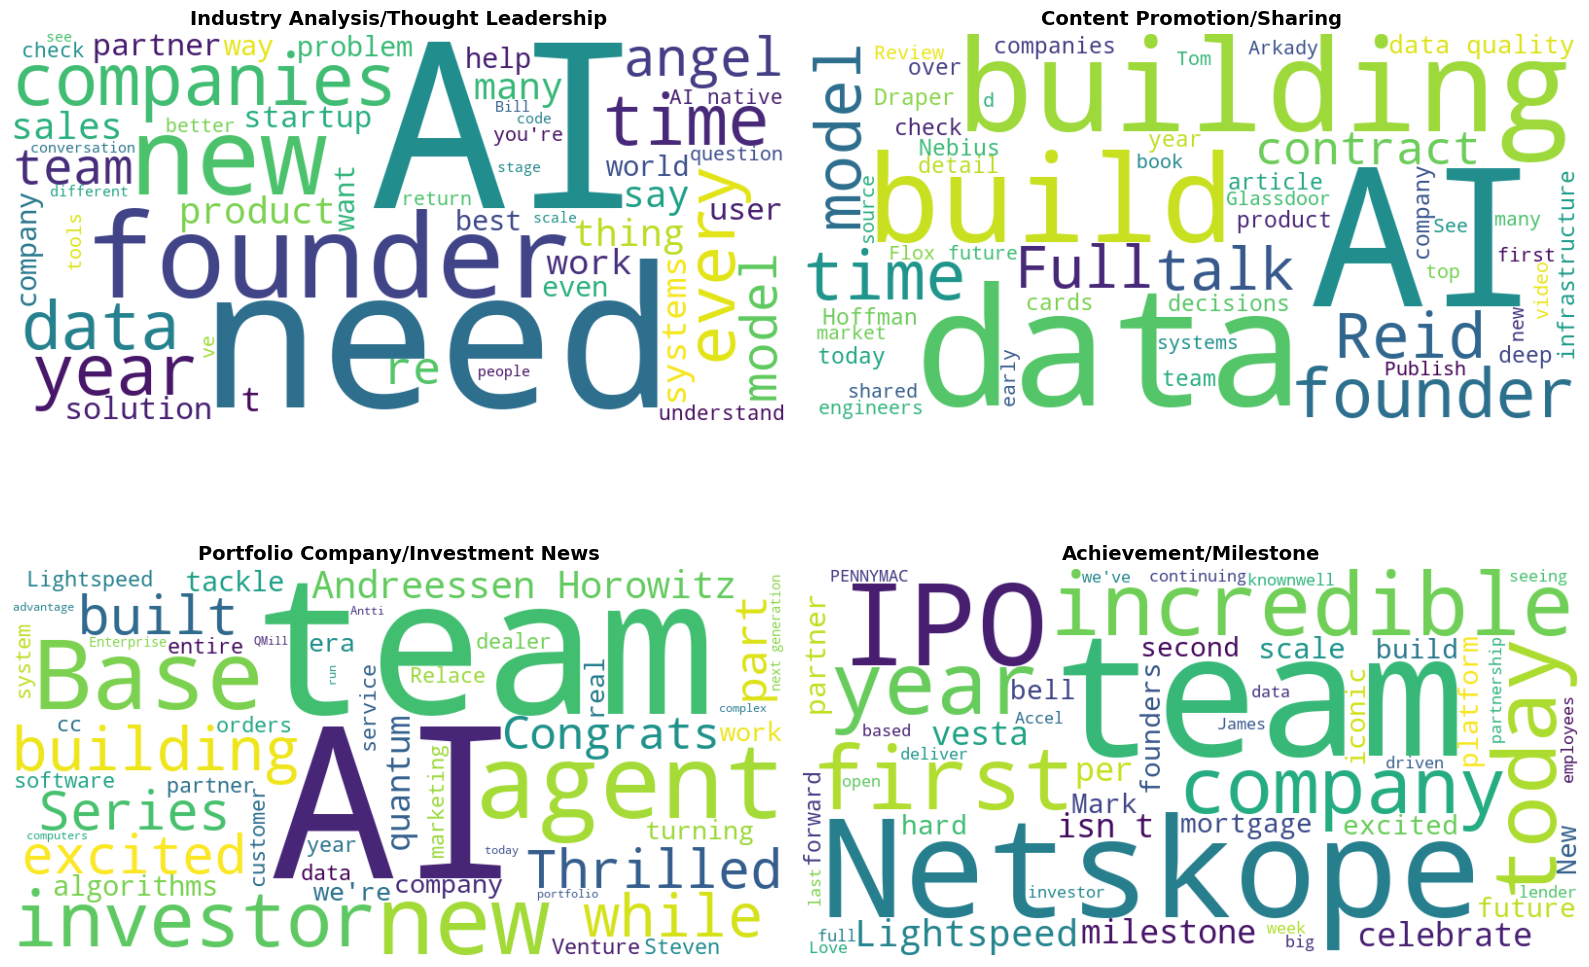

Word clouds generated for top 4 categories (from 100 LLM-classified posts)


In [113]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds for top 4 categories
top_categories = sample_posts['llm_category'].value_counts().head(4).index

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, category in enumerate(top_categories):
    # Get text for this category
    category_text = ' '.join(
        sample_posts[sample_posts['llm_category'] == category]['text'].fillna('').astype(str).tolist()
    )
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=set([
            # URLs and technical terms
            'https', 'http', 'lnkd', 'com', 'www', 'co',
            # Common articles and prepositions
            'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from',
            'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the',
            'to', 'was', 'will', 'with', 'have', 'had', 'not', 'but', 'or',
            'if', 'this', 'they', 'been', 'has', 'their', 'can', 'all', 'were',
            # Pronouns
            'i', 'you', 'we', 'us', 'our', 'my', 'your', 'his', 'her', 'them', 'me',
            # Common verbs
            'am', 'are', 'been', 'being', 'get', 'got', 'do', 'does', 'did',
            'going', 'go', 'goes', 'went', 'make', 'made', 'know', 'like',
            # Modal verbs
            'would', 'could', 'should', 'may', 'might', 'must', 'can', 'will',
            # Common adverbs
            'more', 'most', 'so', 'very', 'just', 'now', 'then', 'than', 'too',
            'also', 'here', 'there', 'when', 'where', 'why', 'how', 'about',
            # Other common words
            'up', 'out', 'what', 'which', 'who', 'into', 'through', 'during',
            'before', 'after', 'above', 'below', 'between', 'under', 'again',
            'further', 'once', 'both', 'each', 'few', 'some', 'such', 'no',
            'nor', 'only', 'own', 'same', 'other', 'any', 'these', 'those', 's', 'one',
            # LinkedIn specific common words to exclude
            'post', 'share', 'comment', 'link', 'profile', 'linkedin'
        ]),
        max_words=50,
        colormap='viridis'
    ).generate(category_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{category}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../output/figures/wordclouds_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("Word clouds generated for top 4 categories (from 100 LLM-classified posts)")

## 8. Writing Style & Tone Analysis

### 8.1 Readability Metrics

In [114]:
from textblob import TextBlob
import textstat

# Calculate readability metrics for posts with sufficient text
def calculate_readability(text):
    """Calculate readability metrics"""
    if pd.isna(text) or len(text) < 50:
        return None
    
    try:
        # Flesch Reading Ease (0-100, higher = easier)
        flesch = textstat.flesch_reading_ease(text)
        return flesch
    except:
        return None

# Apply to posts with text
posts_for_analysis = df[df['text_length'] >= 50].copy()
posts_for_analysis['readability_score'] = posts_for_analysis['text'].apply(calculate_readability)

# Filter valid scores
valid_readability = posts_for_analysis[posts_for_analysis['readability_score'].notna()]

print(f"Calculated readability for {len(valid_readability)} posts")
print(f"\nReadability Statistics:")
print(f"  Mean: {valid_readability['readability_score'].mean():.1f}")
print(f"  Median: {valid_readability['readability_score'].median():.1f}")
print(f"  Std Dev: {valid_readability['readability_score'].std():.1f}")

# Categorize readability
def categorize_readability(score):
    """Categorize Flesch Reading Ease score"""
    if pd.isna(score):
        return 'Unknown'
    elif score >= 80:
        return 'Very Easy'
    elif score >= 60:
        return 'Easy'
    elif score >= 50:
        return 'Fairly Difficult'
    elif score >= 30:
        return 'Difficult'
    else:
        return 'Very Difficult'

valid_readability['readability_category'] = valid_readability['readability_score'].apply(categorize_readability)

# Engagement by readability
readability_engagement = valid_readability.groupby('readability_category').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

readability_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
readability_order = ['Very Easy', 'Easy', 'Fairly Difficult', 'Difficult', 'Very Difficult']
readability_engagement = readability_engagement.reindex(readability_order)

print("\nEngagement by Readability:")
print(readability_engagement)

readability_engagement.to_csv('../output/tables/engagement_by_readability.csv')

Calculated readability for 10853 posts

Readability Statistics:
  Mean: 52.8
  Median: 54.1
  Std Dev: 18.1

Engagement by Readability:
                      Avg_Engagement  Median_Engagement  Post_Count  \
readability_category                                                  
Very Easy                     232.77              79.00         449   
Easy                          341.27             130.00        3400   
Fairly Difficult              380.25             126.50        2686   
Difficult                     317.82             113.00        3274   
Very Difficult                291.76             109.00        1044   

                      Avg_Likes  Avg_Shares  Avg_Comments  
readability_category                                       
Very Easy                208.42        6.09         18.26  
Easy                     297.88       10.84         32.55  
Fairly Difficult         332.32       16.73         31.21  
Difficult                279.20       15.00         23.61  
Very D

### 8.2 Pronoun Usage (Personal vs Professional)

In [115]:
# Analyze pronoun usage
def count_pronouns(text):
    """Count personal and professional pronouns"""
    if pd.isna(text):
        return {'first_person': 0, 'second_person': 0, 'third_person': 0, 'we': 0}
    
    text_lower = text.lower()
    words = text_lower.split()
    
    first_person = sum(1 for w in words if w in ['i', "i'm", "i've", "i'll", 'my', 'mine', 'me'])
    second_person = sum(1 for w in words if w in ['you', 'your', 'yours'])
    third_person = sum(1 for w in words if w in ['he', 'she', 'they', 'his', 'her', 'their'])
    we_pronoun = sum(1 for w in words if w in ['we', "we're", "we've", "we'll", 'our', 'ours', 'us'])
    
    return {
        'first_person': first_person,
        'second_person': second_person,
        'third_person': third_person,
        'we': we_pronoun
    }

# Apply pronoun counting
pronoun_data = df[df['text_length'] > 10]['text'].apply(count_pronouns)
df.loc[df['text_length'] > 10, 'first_person_count'] = pronoun_data.apply(lambda x: x['first_person'])
df.loc[df['text_length'] > 10, 'second_person_count'] = pronoun_data.apply(lambda x: x['second_person'])
df.loc[df['text_length'] > 10, 'we_count'] = pronoun_data.apply(lambda x: x['we'])

# Fill NaN with 0
df[['first_person_count', 'second_person_count', 'we_count']] = df[['first_person_count', 'second_person_count', 'we_count']].fillna(0)

# Categorize writing style
def categorize_writing_style(row):
    """Categorize based on pronoun usage"""
    if row['text_length'] < 10:
        return 'Unknown'
    
    first = row['first_person_count']
    second = row['second_person_count']
    we = row['we_count']
    
    if first > 2:
        return 'Personal (I/My)'
    elif we > 2:
        return 'Collective (We/Our)'
    elif second > 2:
        return 'Direct (You/Your)'
    else:
        return 'Neutral/Impersonal'

df['writing_style'] = df.apply(categorize_writing_style, axis=1)

# Engagement by writing style
style_engagement = df[df['writing_style'] != 'Unknown'].groupby('writing_style').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

style_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
style_engagement = style_engagement.sort_values('Avg_Engagement', ascending=False)

print("Engagement by Writing Style:")
print(style_engagement)

style_engagement.to_csv('../output/tables/engagement_by_writing_style.csv')

Engagement by Writing Style:
                     Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
writing_style                                                                   
Collective (We/Our)          527.85             213.00        1905     458.32   
Personal (I/My)              495.02             208.00        1383     425.38   
Direct (You/Your)            385.82             134.00         701     330.17   
Neutral/Impersonal           237.78              83.00        7179     211.93   

                     Avg_Shares  Avg_Comments  
writing_style                                  
Collective (We/Our)       24.41         45.13  
Personal (I/My)           19.55         50.10  
Direct (You/Your)         18.47         37.19  
Neutral/Impersonal         9.26         16.60  


### 8.3 Sentiment Analysis

In [116]:
# Perform sentiment analysis
def analyze_sentiment(text):
    """Analyze sentiment using TextBlob"""
    if pd.isna(text) or len(text) < 10:
        return None
    
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity  # -1 to 1
    except:
        return None

# Apply sentiment analysis
posts_for_sentiment = df[df['text_length'] >= 10].copy()
posts_for_sentiment['sentiment_score'] = posts_for_sentiment['text'].apply(analyze_sentiment)

# Filter valid scores
valid_sentiment = posts_for_sentiment[posts_for_sentiment['sentiment_score'].notna()]

print(f"Calculated sentiment for {len(valid_sentiment)} posts")
print(f"\nSentiment Statistics:")
print(f"  Mean: {valid_sentiment['sentiment_score'].mean():.3f}")
print(f"  Median: {valid_sentiment['sentiment_score'].median():.3f}")
print(f"  Std Dev: {valid_sentiment['sentiment_score'].std():.3f}")

# Categorize sentiment
def categorize_sentiment(score):
    """Categorize polarity score"""
    if pd.isna(score):
        return 'Unknown'
    elif score > 0.3:
        return 'Very Positive'
    elif score > 0.1:
        return 'Positive'
    elif score > -0.1:
        return 'Neutral'
    elif score > -0.3:
        return 'Negative'
    else:
        return 'Very Negative'

valid_sentiment['sentiment_category'] = valid_sentiment['sentiment_score'].apply(categorize_sentiment)

# Engagement by sentiment
sentiment_engagement = valid_sentiment.groupby('sentiment_category').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

sentiment_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
sentiment_order = ['Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative']
sentiment_engagement = sentiment_engagement.reindex(sentiment_order)

print("\nEngagement by Sentiment:")
print(sentiment_engagement)

sentiment_engagement.to_csv('../output/tables/engagement_by_sentiment.csv')

Calculated sentiment for 11168 posts

Sentiment Statistics:
  Mean: 0.220
  Median: 0.202
  Std Dev: 0.192

Engagement by Sentiment:
                    Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
sentiment_category                                                             
Very Positive               244.85              79.00        2949     219.27   
Positive                    384.97             138.00        5485     336.43   
Neutral                     303.31             116.00        2487     261.94   
Negative                    342.80             100.00         193     303.89   
Very Negative               250.61              69.50          54     226.33   

                    Avg_Shares  Avg_Comments  
sentiment_category                            
Very Positive             8.58         17.00  
Positive                 17.20         31.34  
Neutral                  12.58         28.80  
Negative                  8.79         30.13  
Very Negative           

## 9. Summary: Key Findings (All Parts)

Comprehensive summary of insights from all content analysis.

In [ ]:
print("="*70)print("KEY FINDINGS: CONTENT ANALYSIS (All Parts)")print("="*70)findings = []# PART 1: HASHTAGSif 'num_hashtags' in df.columns:    posts_with_hashtags = (df['num_hashtags'] > 0).sum()    hashtag_pct = posts_with_hashtags / len(df) * 100    findings.append("\n1. HASHTAGS:")    findings.append(f"   - {hashtag_pct:.1f}% of posts contain hashtags ({posts_with_hashtags:,} posts)")    # Engagement comparison    with_hashtags = df[df['num_hashtags'] > 0]['total_engagement'].mean()    without_hashtags = df[df['num_hashtags'] == 0]['total_engagement'].mean()    findings.append(f"   - Posts WITHOUT hashtags: {without_hashtags:.0f} avg engagement")    findings.append(f"   - Posts WITH hashtags: {with_hashtags:.0f} avg engagement")    # Sweet spot    if 'hashtag_count_bin' in df.columns:        best_bin = df.groupby('hashtag_count_bin')['total_engagement'].mean().idxmax()        findings.append(f"   - Best performing: {best_bin} hashtags")# PART 2: EMOJISif 'num_emojis' in df.columns:    posts_with_emojis = (df['num_emojis'] > 0).sum()    emoji_pct = posts_with_emojis / len(df) * 100    findings.append("\n2. EMOJIS:")    findings.append(f"   - {emoji_pct:.1f}% of posts contain emojis ({posts_with_emojis:,} posts)")    # Engagement comparison    with_emojis = df[df['num_emojis'] > 0]['total_engagement'].mean()    without_emojis = df[df['num_emojis'] == 0]['total_engagement'].mean()    findings.append(f"   - Posts WITHOUT emojis: {without_emojis:.0f} avg engagement")    findings.append(f"   - Posts WITH emojis: {with_emojis:.0f} avg engagement")# PART 3: MENTIONSif 'total_mentions' in df.columns:    posts_with_mentions = (df['total_mentions'] > 0).sum()    mention_pct = posts_with_mentions / len(df) * 100    findings.append("\n3. MENTIONS:")    findings.append(f"   - {mention_pct:.1f}% of posts contain mentions ({posts_with_mentions:,} posts)")    # Engagement comparison    with_mentions = df[df['total_mentions'] > 0]['total_engagement'].mean()    without_mentions = df[df['total_mentions'] == 0]['total_engagement'].mean()    findings.append(f"   - Posts WITHOUT mentions: {without_mentions:.0f} avg engagement")    findings.append(f"   - Posts WITH mentions: {with_mentions:.0f} avg engagement")# PART 4: URLsif 'url_category' in df.columns:    findings.append("\n4. URLs:")    url_stats = df.groupby('url_category')['total_engagement'].agg(['mean', 'count'])    best_url = url_stats['mean'].idxmax()    findings.append(f"   - Highest engagement: {best_url} ({url_stats.loc[best_url, 'mean']:.0f} avg)")    findings.append(f"   - Posts with URLs: {(df['url_category'] != 'No URL').sum():,}")# PART 5: TEXT QUALITYif 'has_question' in df.columns and df['has_question'].sum() > 0:    question_pct = df['has_question'].sum() / len(df) * 100    question_eng = df[df['has_question']]['total_engagement'].mean()    no_question_eng = df[~df['has_question']]['total_engagement'].mean()    findings.append("\n5. QUESTIONS:")    findings.append(f"   - {question_pct:.1f}% of posts contain questions")    findings.append(f"   - With question: {question_eng:.0f} avg engagement")    findings.append(f"   - Without question: {no_question_eng:.0f} avg engagement")if 'has_any_cta' in df.columns and df['has_any_cta'].sum() > 0:    cta_pct = df['has_any_cta'].sum() / len(df) * 100    findings.append(f"\n6. CALL-TO-ACTION:")    findings.append(f"   - {cta_pct:.1f}% of posts contain CTAs")if 'structure_type' in df.columns:    best_structure = df.groupby('structure_type')['total_engagement'].mean().idxmax()    best_structure_eng = df.groupby('structure_type')['total_engagement'].mean().max()    findings.append(f"\n7. POST STRUCTURE:")    findings.append(f"   - Best performing: {best_structure} ({best_structure_eng:.0f} avg engagement)")# PART 6: CONTENT CATEGORIES (LLM)if 'sample_posts' in locals() and 'llm_category' in sample_posts.columns:    findings.append("\n8. CONTENT CATEGORIES (100 LLM-classified sample posts):")    top_category = sample_posts['llm_category'].value_counts().iloc[0]    findings.append(f"   - Most common: {sample_posts['llm_category'].value_counts().index[0]} ({top_category} posts)")    if 'category_engagement' in locals() and len(category_engagement) > 0:        best_category = category_engagement.iloc[0]        findings.append(f"   - Highest engagement: {category_engagement.index[0]} ({best_category['Avg_Engagement']:.0f} avg)")# PART 8: WRITING STYLEif 'writing_style' in df.columns:    findings.append("\n9. WRITING STYLE:")    style_counts = df[df['writing_style'] != 'Unknown']['writing_style'].value_counts()    if len(style_counts) > 0:        findings.append(f"   - Most common: {style_counts.index[0]} ({style_counts.iloc[0]:,} posts)")    if 'style_engagement' in locals() and len(style_engagement) > 0:        best_style = style_engagement.iloc[0]        findings.append(f"   - Highest engagement: {style_engagement.index[0]} ({best_style['Avg_Engagement']:.0f} avg)")# PART 8: SENTIMENTif 'valid_sentiment' in locals() and len(valid_sentiment) > 0:    avg_sentiment = valid_sentiment['sentiment_score'].mean()    findings.append("\n10. SENTIMENT:")    findings.append(f"   - Average sentiment score: {avg_sentiment:.3f} (slightly positive)")    if 'sentiment_engagement' in locals() and len(sentiment_engagement) > 0:        best_sentiment = sentiment_engagement.dropna().iloc[0] if len(sentiment_engagement.dropna()) > 0 else None        if best_sentiment is not None:            best_sent_idx = sentiment_engagement.dropna().index[0]            findings.append(f"   - Highest engagement: {best_sent_idx} ({best_sentiment['Avg_Engagement']:.0f} avg)")# Print all findingsfor finding in findings:    print(finding)print("\n" + "="*70)print("KEY INSIGHTS:")print("="*70)print("• Hashtags, emojis, and mentions can reduce engagement - use sparingly")print("• LinkedIn native URLs perform better than external links")print("• Questions and CTAs encourage interaction")print("• Post structure matters - optimal length varies by content type")print("• Writing style impacts engagement - personal vs. professional tone")print("• Sentiment tends slightly positive across all posts")print("="*70)# Save findingswith open('../output/tables/key_findings_all_parts.txt', 'w', encoding='utf-8') as f:    f.write("KEY FINDINGS: CONTENT ANALYSIS (All Parts)\n")    f.write("="*70 + "\n")    for finding in findings:        f.write(finding + "\n")    f.write("\n" + "="*70 + "\n")    f.write("KEY INSIGHTS:\n")    f.write("="*70 + "\n")    f.write("• Hashtags, emojis, and mentions can reduce engagement - use sparingly\n")    f.write("• LinkedIn native URLs perform better than external links\n")    f.write("• Questions and CTAs encourage interaction\n")    f.write("• Post structure matters - optimal length varies by content type\n")    f.write("• Writing style impacts engagement - personal vs. professional tone\n")    f.write("• Sentiment tends slightly positive across all posts\n")print("\nAnalysis complete! Results saved to ../output/")print("\nNote: Content category analysis based on 100 LLM-classified sample posts (proof of concept).")